## CONTENT BASED RECOMMENDER SYSTEM [ based on movies keywords, cast, director(from crew dataset) and genres ]

This is more personalized. As this computes similarities between movies based on Movie Cast, Crew, Keywords and Genre.
Used movie metadata (or content) to build this engine, this also known as Content Based Filtering. Used subset of movie due to limited computing power.

1. Preprocessed the data:
                  1.1 Cleaned the data ( manually verified and removed data with wrong format )
                  1.2 Merged credits and keywords csv to the original dataset ie, movies_data
                  1.3 Used only those movie which is present in links_small dataset ( it is a dataset which links movieid with imdb and tmdbid )
    
2. Created a column name soup which contains director, cast, keywords and genres of the movie. Director name is written three times to give more weightage to the director and only top three cast name is taken.

3. Then used Count Vectorizer to create the count matrix and then applied cosine similarity to calculate a numeric quantity that denotes the similarity between two movies.

4. Finally, movies are recommended on the basis of cosine similarity values. Higher its value more is movie similar to that movie.

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval  # evaluate strings containing Python code in the current Python environment
from nltk.stem.snowball import SnowballStemmer # Removing stem words
from sklearn.feature_extraction.text import CountVectorizer  # To convert text to numerical data
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from collections import defaultdict
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import seaborn as sns
import networkx as nx

import warnings  # disable python warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading datasets

movies_data = pd.read_csv("dataset/movies_metadata.csv", low_memory=False)
credits = pd.read_csv('dataset/credits.csv')
keywords = pd.read_csv('dataset/keywords.csv')
links_small = pd.read_csv('dataset/links_small.csv')
ratings = pd.read_csv("dataset/ratings_small.csv")

In [3]:
movies_data.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [4]:
# Checking for null values in the dataset

print(movies_data.isnull().sum(),'\n') # used only selected column of the dataset which include genres,id,vote_average,vote_count
print(links_small.isnull().sum(),'\n')
print(ratings.isnull().sum(),'\n')
print(keywords.isnull().sum(),'\n')
print(credits.isnull().sum(),'\n')

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64 

movieId     0
imdbId      0
tmdbId     13
dtype: int64 

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 

id          0
keywords    0
dtype: int64 

cast    0
crew    0
id      0
dtype: int64 



In [5]:
# Removing the rows with null value in the vote_average and vote_count columns in movies_data dataframe

movies_data = movies_data.dropna(subset=['vote_average', 'vote_count'])
print(movies_data.isnull().sum(),'\n')

adult                        0
belongs_to_collection    40970
budget                       0
genres                       0
homepage                 37682
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   0
poster_path                383
production_companies         0
production_countries         0
release_date                84
revenue                      0
runtime                    257
spoken_languages             0
status                      81
tagline                  25048
title                        0
video                        0
vote_average                 0
vote_count                   0
dtype: int64 



In [6]:
#Preprocessing the data

movies_data['id'] = movies_data['id'].astype('int')  #The astype() function is used to cast a pandas object to a specified data type.

# merging both credits and keywords in movies_data on the basis of movie id
movies_data = movies_data.merge(credits, on='id')
movies_data = movies_data.merge(keywords, on='id')

links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

# taking only those movies whos id is present in link_small because of limited computing power
smd = movies_data[movies_data['id'].isin(links_small)]
smd = smd.reset_index()

smd.head()

,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [7]:
def get_director(x):

    '''

    This function gives the name of first director occuring in the crew of the movie

    Parameters: x(list of dictionary): List containing name and corrosponding role of complete cast of the movie

    Returns: (string) It returns the first director name that appear in the list

    '''

    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan


# Applying literal_eval to get the right data type from the expression of string
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['genres'] = smd['genres'].apply(literal_eval)

smd['director'] = smd['crew'].apply(get_director)

# Taking all the movie cast in a list and then taking only the top 3 cast
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])# Strip Spaces and Convert to Lowercase

smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

smd['genres'] = smd['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['genres'] = smd['genres'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])  # giving more weight to the director relative to the entire cast

In [8]:
def filter_keywords(x):

    '''

    This funtion remove those keywords which occur only once

    Parameters: x(list): List containing keywords of the movie

    Returns: (list) It returns a list containg only those keywords which are present in keywords_count ( it is a dictionary containg those keywords which occur more than once )

    '''

    words = []
    for i in x:
        if i in keywords_count.keys():
            words.append(i)
    return words


# Creating the count of every keywords
keywords_count = dict()
for i in range(len(smd['keywords'])):
    for j in range(len(smd['keywords'][i])):
        if smd['keywords'][i][j] not in keywords_count.keys():
            keywords_count[smd['keywords'][i][j]] = 0
        keywords_count[smd['keywords'][i][j]] +=1

# removing those keywords which occur only once
for i in list(keywords_count):
    if keywords_count[i] == 1:
        del keywords_count[i]

In [9]:
# preprocessing

# Stemming the words
stemmer = SnowballStemmer('english')

smd['keywords'] = smd['keywords'].apply(filter_keywords) # removing those keywords which occur only once
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

# combining keywords, cast, director and genres
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))
smd['soup'][0]

'jealousi toy boy friendship friend rivalri boynextdoor newtoy toycomestolif tomhanks timallen donrickles johnlasseter johnlasseter johnlasseter animation comedy family'

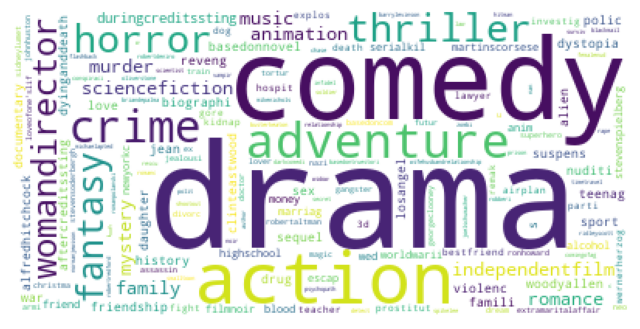

In [10]:
# Creating the Wordcloud for visualisation of the word which occur frequently in the dataset

# Combining all the text contained in smd['soup'] column
text = ""
for i in smd['soup']:
    text +=i

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
# plot the WordCloud image
plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")

plt.show()

In [11]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2) ,min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

cosine_sim = cosine_similarity(count_matrix, count_matrix)

titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])  # Creating a mapping between movie and title and index

In [12]:
df_cosine=pd.DataFrame(cosine_sim)
df_cosine

,0,1,2,3,4,5,6,7,8,9,...,9209,9210,9211,9212,9213,9214,9215,9216,9217,9218
0,1.000000,0.024419,0.027390,0.025777,0.024419,0.000000,0.026547,0.029348,0.000000,0.000000,...,0.000000,0.000000,0.023816,0.000000,0.020947,0.030500,0.000000,0.000000,0.000000,0.0
1,0.024419,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061633,0.027067,0.021592,...,0.000000,0.000000,0.050016,0.000000,0.000000,0.000000,0.000000,0.029735,0.025641,0.0
2,0.027390,0.000000,1.000000,0.060718,0.028760,0.000000,0.062531,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.024671,0.000000,0.034565,0.033352,0.000000,0.0
3,0.025777,0.000000,0.060718,1.000000,0.027067,0.019263,0.058849,0.032530,0.000000,0.000000,...,0.000000,0.023669,0.026398,0.033806,0.023218,0.033806,0.032530,0.062776,0.027067,0.0
4,0.024419,0.000000,0.028760,0.027067,1.000000,0.000000,0.027875,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.021995,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214,0.030500,0.000000,0.000000,0.033806,0.000000,0.022792,0.000000,0.038490,0.000000,0.000000,...,0.000000,0.028006,0.031235,0.040000,0.000000,1.000000,0.000000,0.037139,0.032026,0.0
9215,0.000000,0.000000,0.034565,0.032530,0.000000,0.021932,0.033501,0.000000,0.032530,0.025950,...,0.000000,0.026948,0.000000,0.038490,0.000000,0.000000,1.000000,0.071474,0.000000,0.0
9216,0.000000,0.029735,0.033352,0.062776,0.000000,0.021162,0.032325,0.107211,0.031388,0.025039,...,0.000000,0.026003,0.087002,0.037139,0.000000,0.037139,0.071474,1.000000,0.089205,0.0
9217,0.000000,0.025641,0.000000,0.027067,0.000000,0.036497,0.000000,0.154083,0.081200,0.043183,...,0.000000,0.022422,0.125039,0.032026,0.065986,0.032026,0.000000,0.089205,1.000000,0.0


<AxesSubplot:>

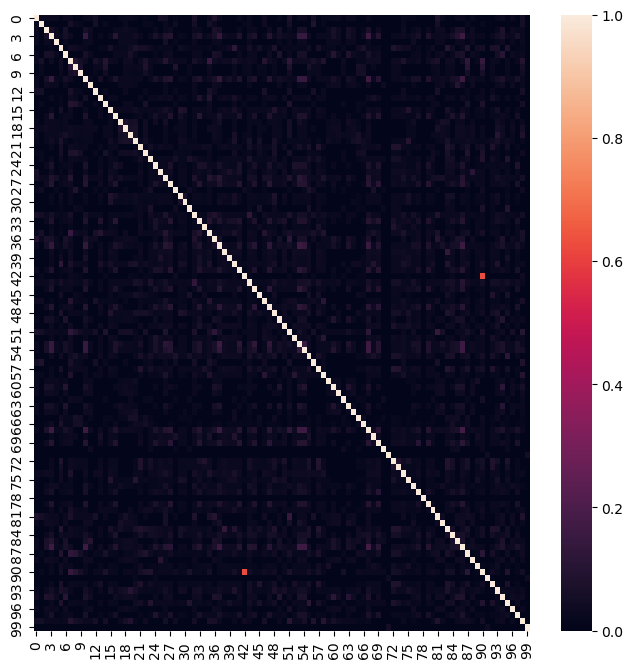

In [13]:
# Creating Heatmap for visualization of correlation between different movies

#specify size of heatmap
fig, ax = plt.subplots(figsize=(8, 8))

#create seaborn heatmap of only top 100 movies
sns.heatmap(cosine_sim[:100,:100])

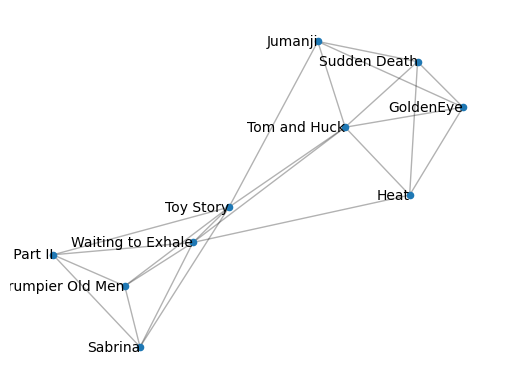

In [14]:
# Graph structure to visualize similarity relation between selected movies

g = nx.Graph()
n = 10

for i in range(n):
    g.add_node(titles[i])

for i in range(n):
    for j in range(n):
        if i != j and cosine_sim[i][j]>0:
            g.add_edge(titles[i],titles[j],weight = cosine_sim[i][j])

g = g.to_undirected()
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, node_size = 20)
nx.draw_networkx_edges(g, pos,alpha = 0.3)
nx.draw_networkx_labels(g, pos, font_size=10, horizontalalignment="right")

plt.axis("off")
plt.show()

In [15]:
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
The Last Brickmaker in America                        9214
Rustom                                                9215
Mohenjo Daro                                          9216
Shin Godzilla                                         9217
The Beatles: Eight Days a Week - The Touring Years    9218
Length: 9219, dtype: int64

In [21]:
def get_recommendations(title):
    idx = indices[title] # movie id corrosponding to the given title
    sim_scores = list(enumerate(cosine_sim[idx])) # list of cosine similarity scores value along the given index
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # sorting the given scores in ascending order
    sim_scores = sim_scores[1:31] # Taking only the top 30 scores
    movie_indices = [i[0] for i in sim_scores] # Finding the indices of 30 most similar movies
    return titles.iloc[movie_indices]

print("Recommendations for The Dark Knight:\n",get_recommendations('The Dark Knight').head(10))

print("\nRecommendations for Star Wars:\n",get_recommendations('Star Wars').head(10))

Recommendations for The Dark Knight:
 8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

Recommendations for Star Wars:
 2120       Star Wars: Episode I - The Phantom Menace
4137    Star Wars: Episode II - Attack of the Clones
6199    Star Wars: Episode III - Revenge of the Sith
970                          The Empire Strikes Back
4789                                        THX 1138
983                               Return of the Jedi
2705                               American Graffiti
7088                       Star Wars: The Clone Wars
8865                    Star Wars: The Force Awakens
8079                Journey 2: The Mysterious Island
Name: title, dtype: ob